# Impact Probability to Inferred Infinity Velocity
Written by Jackey Fang<br>
<br>
**Last Update**<br>
2026-02-24

In [10]:
import matplotlib.pyplot as plt
import requests
import time
import numpy as np
import seaborn as sns
from astropy.table import QTable, vstack

# API

In [11]:
def fetch_sentry_vimp(input_file, output_file):
    # Load the Mode S data using astropy
    print(f"Loading data from {input_file}...")
    table = QTable.read(input_file, format='ascii.ecsv')
    
    v_imp_list = []
    total_objects = len(table)
    
    print(f"Fetching Mode O data for {total_objects} asteroids...")

    for index, des in enumerate(table['des']):
        url = f"https://ssd-api.jpl.nasa.gov/sentry.api?des={des}"
        
        try:
            response = requests.get(url, timeout=10)
            
            if response.status_code == 200:
                data = response.json()
                
                if 'removed' in data:
                    v_imp_list.append(np.nan)
                # Extract v_imp
                elif 'summary' in data and 'v_imp' in data['summary']:
                    v_imp_list.append(float(data['summary']['v_imp']))
                else:
                    v_imp_list.append(np.nan)
            else:
                v_imp_list.append(np.nan)
                
        except requests.exceptions.RequestException as e:
            print(f"Network error on {des}: {e}")
            v_imp_list.append(np.nan)
            
        # Rate limits
        time.sleep(0.1)

    # Append the new column to the QTable
    table['v_imp'] = v_imp_list
    
    # Save the updated table
    table.write(output_file, format='ascii.ecsv', overwrite=True)
    print(f"Finished adding v_imp. File saved to {output_file}")

In [12]:
fetch_sentry_vimp('data/nasa_ipcum.ecsv', 'data/nasa_ipcum_with_vimp.ecsv')

Loading data from data/nasa_ipcum.ecsv...
Fetching Mode O data for 2067 asteroids...
Finished adding v_imp. File saved to data/nasa_ipcum_with_vimp.ecsv


In [17]:
nasa_raw = QTable.read('data/nasa_ipcum_with_vimp.ecsv', format='ascii.ecsv')
nasa_vimp = nasa_raw["v_imp"]

# Conversion

In [22]:
def est_vinf(vimp):
    MU = 398600.435436
    R_EARTH = 6378.137
    energy = 0.5 * (vimp ** 2) - MU / R_EARTH
    vinf = np.sqrt(np.maximum(2 * energy, 0.0))

    return vinf

In [37]:
nasa_vinf_est = est_vinf(nasa_vimp)

# Plot

In [35]:
def plot_vinf_ip(table, vinf_col='v_inf', est_vinf_col=nasa_vinf_est, ip_col='ip'):
    # Extract data
    vinf = np.array(table[vinf_col], dtype=float)
    est_vinf = np.array(est_vinf_col, dtype=float)
    ip = np.array(table[ip_col], dtype=float)
    
    mask_actual = np.isfinite(vinf) & np.isfinite(ip) & (ip > 0)
    mask_est = np.isfinite(est_vinf) & np.isfinite(ip) & (ip > 0)

    # Round V_inf to group by every 1 km/s
    bin_size = 1
    actual_vinf_binned = np.round(vinf[mask_actual] / bin_size) * bin_size
    est_vinf_binned = np.round(est_vinf[mask_est] / bin_size) * bin_size

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set_style('whitegrid')

    sns.lineplot(
        x = actual_vinf_binned,
        y = ip[mask_actual],
        alpha = 0.6,
        estimator = np.median,
        errorbar = ('pi', 100),
        color = 'green',
        linewidth = 2,
        ax = ax,
        label = 'Actual $V_{inf}$'
    )
    
    sns.lineplot(
        x = est_vinf_binned,
        y = ip[mask_est],
        alpha = 1,
        estimator = np.median,
        errorbar = ('pi', 100),
        color = 'royalblue',
        linestyle = '--',
        linewidth = 2,
        ax = ax,
        label = 'Estimated $V_{inf}$'
    )
    ax.set_yscale('log')
    ax.invert_xaxis()

    ax.set_title(r"NASA Sentry Impact Probability vs. $V_{inf}$")
    ax.set_ylabel("Cumulative Impact Probability (log)")
    ax.set_xlabel("$V_{inf}$ (km/s)")
    ax.legend();

    plt.tight_layout()
    plt.show()

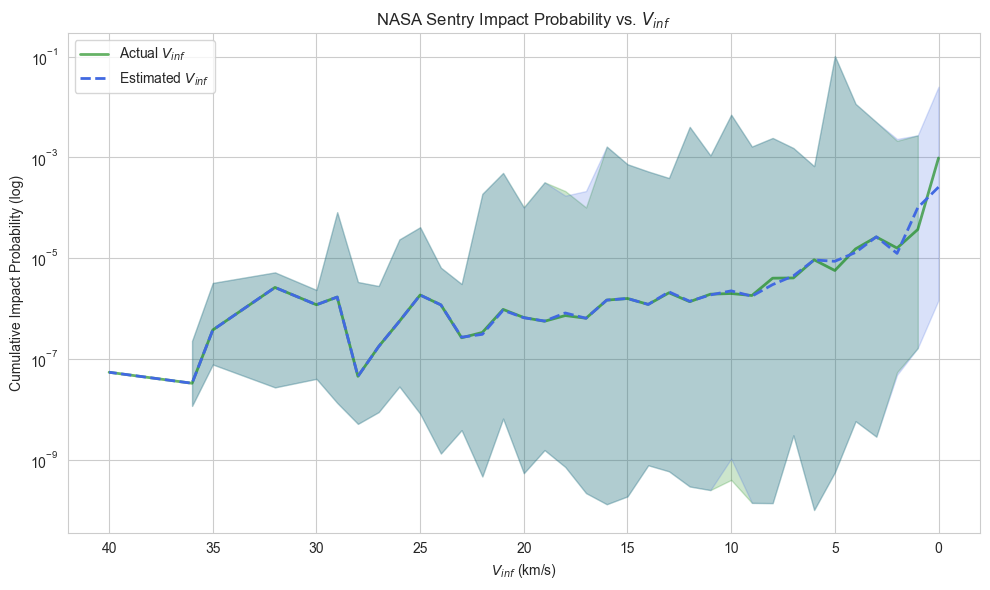

In [36]:
plot_vinf_ip(nasa_raw)